In [90]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np
import pandas as pd
import glob
from scipy.stats import pearsonr, spearmanr
from matplotlib.pyplot import cm

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

import matplotlib.pyplot as plt

result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"
behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"



In [91]:
def plottable_data (subs, cond):

    ispc_list = []
    swi_list = []
    alpha_list = []
    alphalin_list = []
    sub_list = []

    for subj in subs:

        # do the behavioral analysis and get the epochs
        df = pd.read_csv(op.join(behav_path, str(subj) + ".csv"))
        df = calculate_alpha(df)

        # load the eeg based data
        swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

        # remove all the trials that were removed by autoreject
        bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
        double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

        # remove the epochs marked as bad from autoreject
        df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

        # add the positive trial indices to remove double taps
        trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

        # remove the epochs marked as bad from double taps
        df = df[np.logical_not(df["trial"].isin(double_taps))]
        swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])
        ispcs = np.array([vals for trial, vals in zip(trial_n, ispcs) if trial not in double_taps])

        trials = set(df["trial"])

        alphas = []
        alphalins = []
        for trial in trials:
            df_filt = df[df["trial"] == trial]

            if cond == "early":
                start = df_filt["ttap"].min()
                stop = start + 1.5
            else:
                stop = df_filt["ttap"].max()
                start = stop - 1.5

            df_frame = df_filt[np.logical_and(df_filt["ttap"] >= start, df_filt["ttap"] <= stop)]
            df_frame = df_frame.dropna()

            alphas.append(df_frame["alpha"].mean())
            alphalins.append(df_frame["alpha_lin"].mean())

        # add them to the lists:
        ispc_list.append(ispcs)
        swi_list.append(swis)
        alpha_list.append(alphas)
        alphalin_list.append(alphalins)
        print(len(alphalins), subj)
        sub_list.append(list(np.repeat(subj,len(alphalins))))

    ispc_list = np.concatenate([i for i in ispc_list], axis=0)
    swi_list = np.concatenate([i for i in swi_list], axis=0)
    alpha_list = np.concatenate([i for i in alpha_list], axis=0)
    alphalin_list = np.concatenate([i for i in alphalin_list], axis=0)
    sub_list = np.concatenate([i for i in sub_list], axis=0)
    
    indices = [idx for idx, val in enumerate(alpha_list) if not np.isnan(val)]

    ispc_list = ispc_list[indices]
    swi_list = swi_list[indices]
    alpha_list = alpha_list[indices]
    alphalin_list = alphalin_list[indices]
    sub_list = sub_list[indices]
    
    ispc_inter = ispc_list[:, :64,64:,:]
    ispc_intra = ispc_list[:,64:,:129,:]
    
    return ispc_list, swi_list, alphalin_list, sub_list, ispc_inter, ispc_intra

In [92]:
# Load frequency list
freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(203) + "_" + "early"))[0].freqs
freqs_list = [round(i,2) for i in freqs]
freqs_list_strings = [str(round(i,2)) for i in freqs]

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/203_early ...


<ipython-input-92-75ee829ed818>:2: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/203_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(203) + "_" + "early"))[0].freqs


Not setting metadata


In [93]:
# List of available datasets
subs = ["202", "203", "204", "205", "206", "207", "208", "209", "211", "212"]

ispc_early, swi_early, alphalin_early, sub_list_early, ispc_inter_early,ispc_intra_early = plottable_data(subs, "early")
ispc_late, swi_late, alphalin_late, sub_list_late ,ispc_inter_late, ispc_intra_late = plottable_data(subs, "late")

192 202
128 203
110 204
50 205
71 206
49 207
82 208
120 209
170 211
53 212
192 202
128 203
110 204
50 205
71 206
49 207
82 208
120 209
170 211
53 212


In [94]:
# Create dataframe with all SWI-alpha ()
# EARLY df
columns = ["Pair","SWI_mean", "alpha_lin"]
df_early = pd.DataFrame(columns=columns)
df_early["Pair"] = sub_list_early
df_early["alpha_lin"] = alphalin_early

# SWI-average over frequencies: same shape as alphalin
df_early["SWI_mean"] = np.mean(swi_early, axis=1)


In [95]:
# Create dataframe with all SWI-alpha ()
# LATE df
df_late = pd.DataFrame(columns=columns)
df_late["Pair"] = sub_list_late
df_late["alpha_lin"] = alphalin_late
# SWI-average over frequencies: same shape as alphalin
df_late["SWI_mean"] = np.mean(swi_late, axis=1)

In [8]:
#df_early.to_csv("df_swi_alpha_early.csv")
#df_late.to_csv("df_swi_alpha_late.csv")

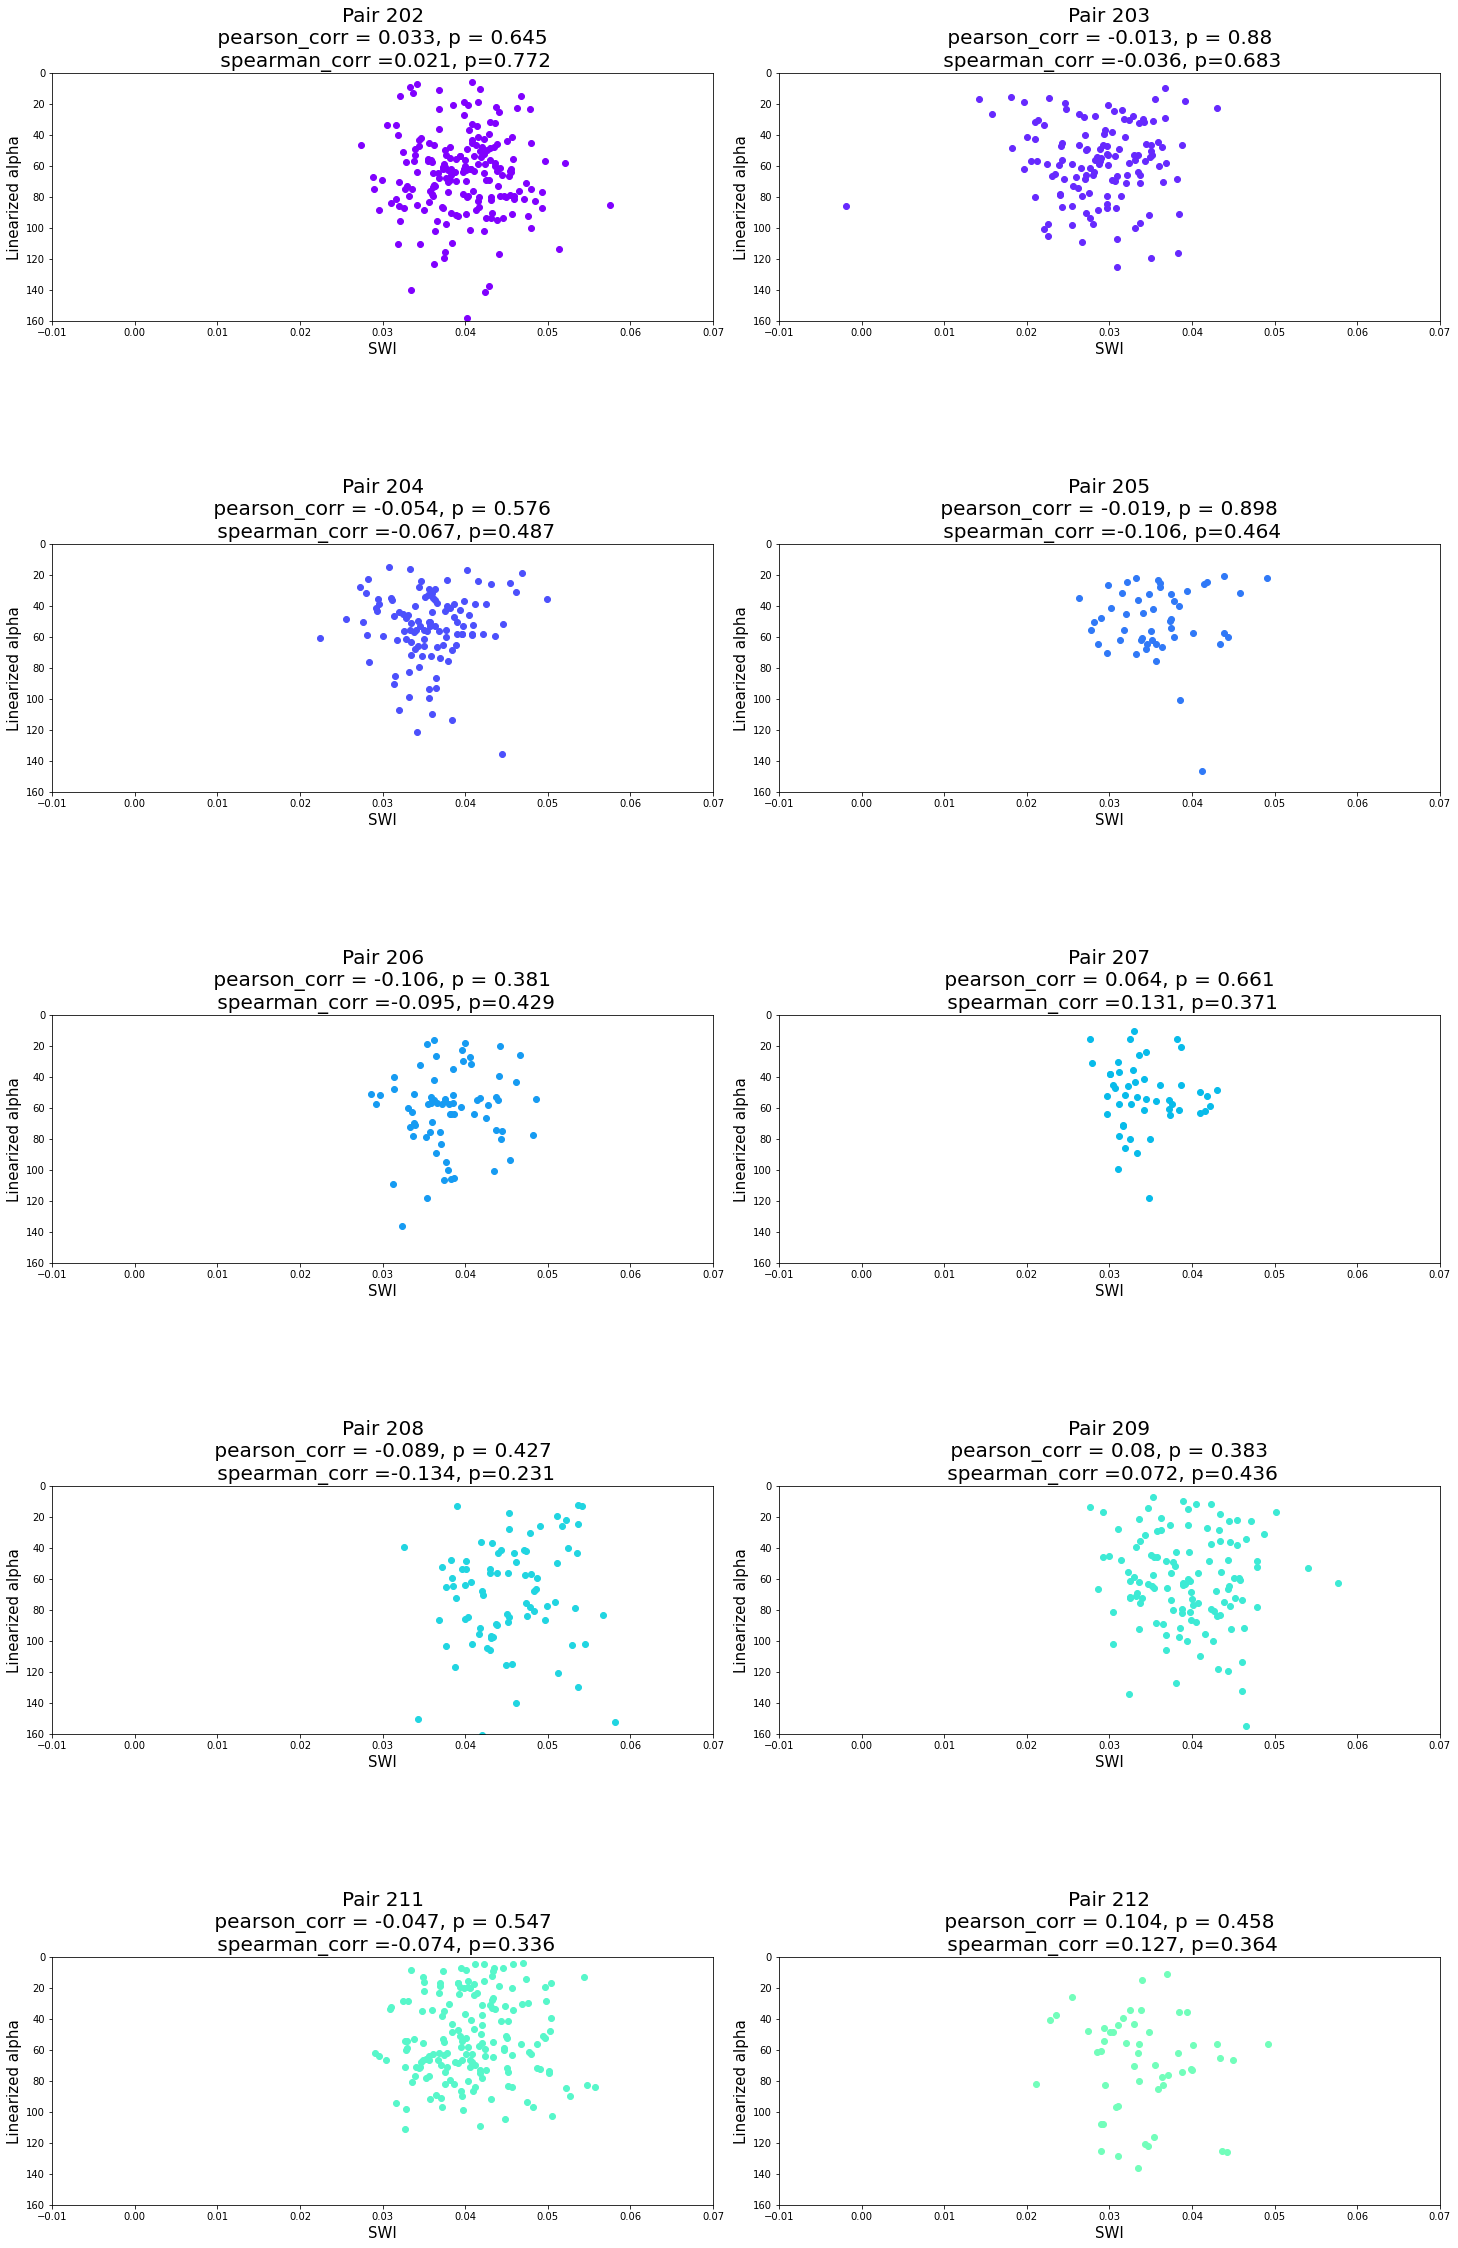

In [89]:
fig, axs = plt.subplots(5,2, figsize=(20, 30))
#fig.subtitle("SWI vs Alpha for all trials in condition late",fontsize=25)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.9, wspace=.1,top=1.0)
axs = axs.ravel()
color=iter(cm.rainbow(np.linspace(0,1,20)))

groups = df_early.groupby("Pair")
i = 0
for name, group in groups:
    rho, sig = pearsonr(group["SWI_mean"], group["alpha_lin"]) 
    coef, p = spearmanr(group["SWI_mean"], group["alpha_lin"])
    c=next(color)

    axs[i].scatter(group["SWI_mean"], group["alpha_lin"], color=c)
    axs[i].set_ylim(160,0)    
    axs[i].set_xlim(-0.01, 0.07)  
    axs[i].set_title("Pair {0}\n pearson_corr = {1}, p = {2} \n spearman_corr ={3}, p={4}".format(name,round(rho,3), round(sig,3), round(coef,3), round(p,3)),fontsize=20)
    axs[i].set_xlabel("SWI",fontsize=15)
    axs[i].set_ylabel("Linearized alpha",fontsize=15)
    i+=1
#fig.legend(name, title ="Pair",fontsize=15, loc = "center right")
#fig.savefig('SWI_alpha_earl_allPairs.png',bbox_inches = "tight")

NameError: name 'label' is not defined

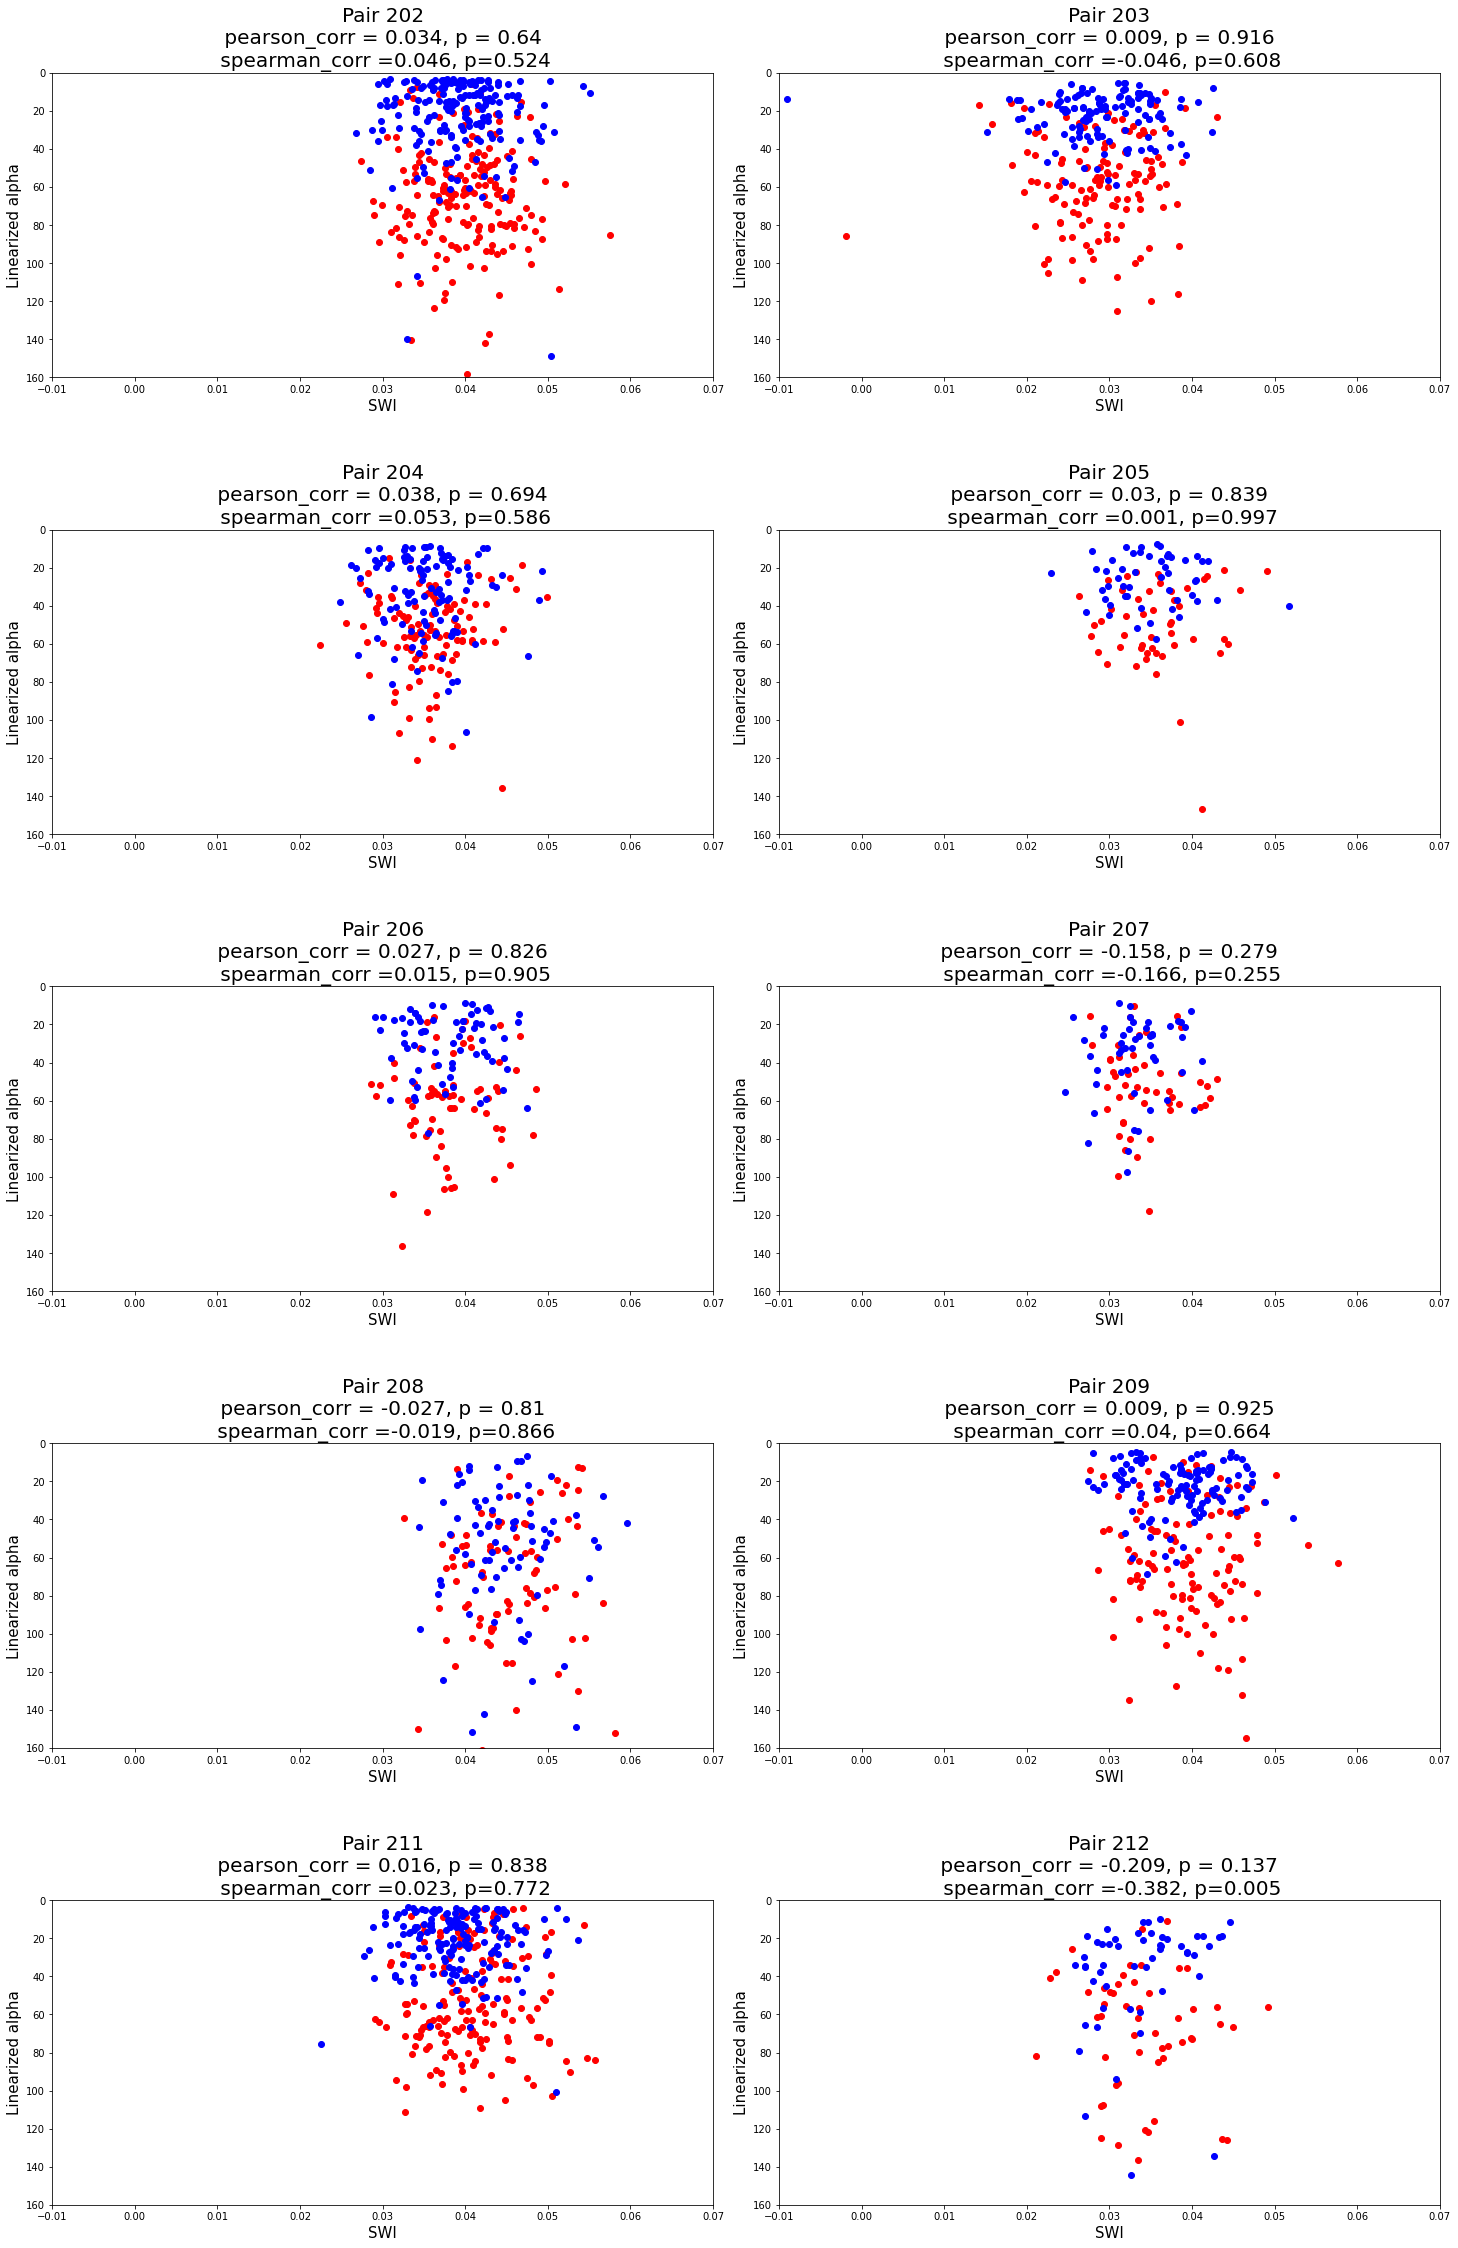

In [107]:
fig, axs = plt.subplots(5,2, figsize=(20, 30))
#fig.subtitle("SWI vs Alpha for all trials in condition late",fontsize=25)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.5, wspace=.1,top=1.0)
axs = axs.ravel()
color=iter(cm.rainbow(np.linspace(0,1,20)))

groups = df_early.groupby("Pair")
i = 0
for name, group in groups:
    rho, sig = pearsonr(group["SWI_mean"], group["alpha_lin"]) 
    coef, p = spearmanr(group["SWI_mean"], group["alpha_lin"])
    c=next(color)

    axs[i].scatter(group["SWI_mean"], group["alpha_lin"], color='r')
    axs[i].set_ylim(160,0)    
    axs[i].set_xlim(-0.01, 0.07)  
    axs[i].set_title("Pair {0}\n pearson_corr = {1}, p = {2} \n spearman_corr ={3}, p={4}".format(name,round(rho,3), round(sig,3), round(coef,3), round(p,3)),fontsize=20)
    axs[i].set_xlabel("SWI",fontsize=15)
    axs[i].set_ylabel("Linearized alpha",fontsize=15)
    i+=1

groups = df_late.groupby("Pair")
i = 0
for name, group in groups:
    rho, sig = pearsonr(group["SWI_mean"], group["alpha_lin"]) 
    coef, p = spearmanr(group["SWI_mean"], group["alpha_lin"])
    c=next(color)

    axs[i].scatter(group["SWI_mean"], group["alpha_lin"], color='b')
    axs[i].set_ylim(160,0)    
    axs[i].set_xlim(-0.01, 0.07)  
    axs[i].set_title("Pair {0}\n pearson_corr = {1}, p = {2} \n spearman_corr ={3}, p={4}".format(name,round(rho,3), round(sig,3), round(coef,3), round(p,3)),fontsize=20)
    axs[i].set_xlabel("SWI",fontsize=15)
    axs[i].set_ylabel("Linearized alpha",fontsize=15)
    i+=1
    
#fig.savefig('SWI_alpha_early_late_allPairs.png',bbox_inches = "tight")

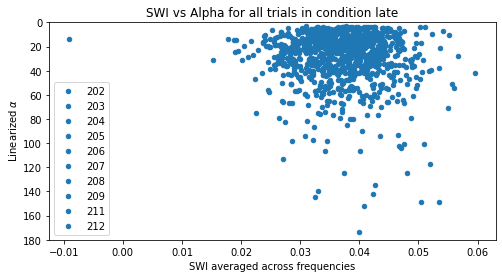

In [19]:
_, ax = plt.subplots(figsize=(8,4))

for idx, gp in df_late.groupby('Pair'):
    gp.reset_index(inplace=True)
    gp.plot.scatter(y='alpha_lin', x = 'SWI_mean',  ax=ax,label=idx,title='SWI vs Alpha for all trials in condition late')
    ax.set_xlabel('SWI averaged across frequencies')
    ax.set_ylabel(r" Linearized $\alpha$")
    ax.set_ylim(180, 0) 


#plt.show()

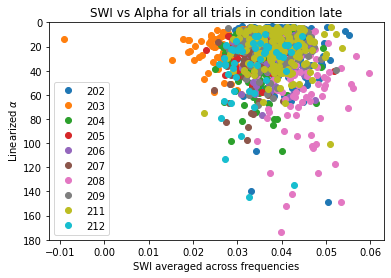

In [17]:
groups = df_late.groupby("Pair")
for name, group in groups:
    plt.plot(group["SWI_mean"], group["alpha_lin"], marker="o", linestyle="", label=name)
    plt.title("SWI vs Alpha for all trials in condition late")
    plt.xlabel("SWI averaged across frequencies")
    plt.ylabel(r" Linearized $\alpha$")
    # convert y-Axis such that alpha=180 (lower synchrony) is at the bottom
    plt.ylim(180, 0) 
    plt.legend()

(180.0, 0.0)

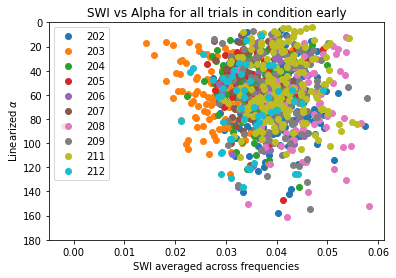

In [20]:
groups = df_early.groupby("Pair")
for name, group in groups:
    plt.plot(group["SWI_mean"], group["alpha_lin"], marker="o", linestyle="", label=name)
plt.legend()
plt.title("SWI vs Alpha for all trials in condition early")
plt.xlabel("SWI averaged across frequencies")
plt.ylabel(r" Linearized $\alpha$")
plt.ylim(180, 0) 

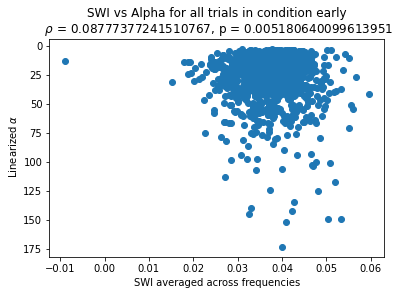

In [22]:
# np.mean(ispc_inter, axis=(1,2,3))
x_late  = np.mean(swi_late, axis=1)
y_late = alphalin_late
rho, sig = pearsonr(x_late, y_late)
cond = "early"
plt.scatter(x_late, y_late)
plt.title("SWI vs Alpha for all trials in condition {0}\n $\\rho$ = {1}, p = {2}".format(cond, rho, sig))
plt.xlabel("SWI averaged across frequencies")
plt.ylabel(r" Linearized $\alpha$")
plt.gca().invert_yaxis()

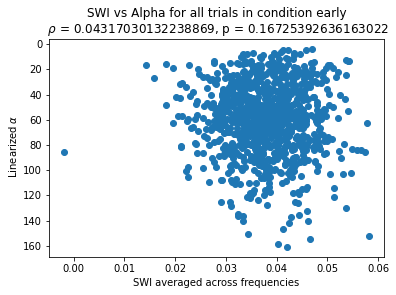

In [23]:
from scipy.stats import pearsonr

# np.mean(ispc_inter, axis=(1,2,3))
x_early = np.mean(swi_early, axis=1)
y_early = alphalin_early
rho, sig = pearsonr(x_early, y_early)

plt.scatter(x_early ,y_early)
plt.title("SWI vs Alpha for all trials in condition {0}\n $\\rho$ = {1}, p = {2}".format(cond, rho, sig))
plt.xlabel("SWI averaged across frequencies")
plt.ylabel(r" Linearized $\alpha$")
plt.gca().invert_yaxis()

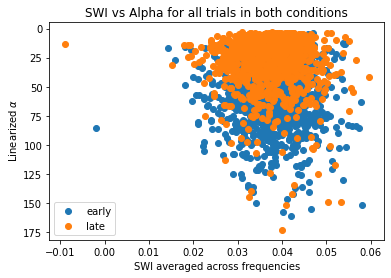

In [24]:
# np.mean(ispc_inter, axis=(1,2,3))
x_early = np.mean(swi_early, axis=1)
y_early = alphalin_early

plt.scatter(x_early, y_early)
plt.scatter(x_late, y_late)
plt.title("SWI vs Alpha for all trials in both conditions")
plt.xlabel("SWI averaged across frequencies")
plt.ylabel(r" Linearized $\alpha$")
          
plt.legend(["early", "late"])
plt.gca().invert_yaxis()
plt.savefig('SWI_alpha_avg.pdf')

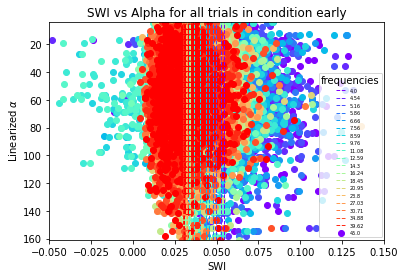

In [25]:
color=iter(cm.rainbow(np.linspace(0,1,20)))

for freq_i in range(len(freqs_list)):
    swi = swi_early[:,freq_i]
    # np.mean(ispc_inter, axis=(1,2,3))
    x_early = swi
    y_early = alphalin_early

    rho, sig = pearsonr(x_early, y_early)
    c=next(color)
    plt.scatter(x_early ,y_early, color=c)
    plt.ylim(max(y_early), min(y_early))    
    plt.title("SWI vs Alpha for all trials in condition early")
    plt.xlabel("SWI")    
    plt.xlim(-0.05, 0.15)  
    plt.ylabel(r" Linearized $\alpha$")
    plt.legend(freqs_list, title ="frequencies", fontsize=5)
    plt.axvline(x_early.mean(), color=c, linestyle='dashed', linewidth=1)

plt.savefig('SWI_alpha_early_all.pdf')

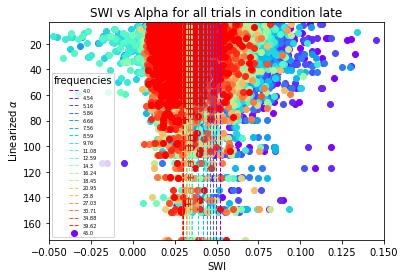

In [26]:
color=iter(cm.rainbow(np.linspace(0,1,20)))


for freq_i in range(len(freqs_list)):
    swi = swi_late[:,freq_i]
    # np.mean(ispc_inter, axis=(1,2,3))
    x_late = swi
    y_late = alphalin_late
    c=next(color)
    plt.scatter(x_late ,y_late, color=c)
    plt.ylim(max(y_late), min(y_late))    
    plt.xlim(-0.05, 0.15)  
    plt.title("SWI vs Alpha for all trials in condition late")
    plt.xlabel("SWI")
    plt.ylabel(r" Linearized $\alpha$")
    plt.legend(freqs_list, title ="frequencies",fontsize=5)
    plt.axvline(x_late.mean(), color=c, linestyle='dashed', linewidth=1)
plt.savefig('SWI_alpha_late_all.pdf')

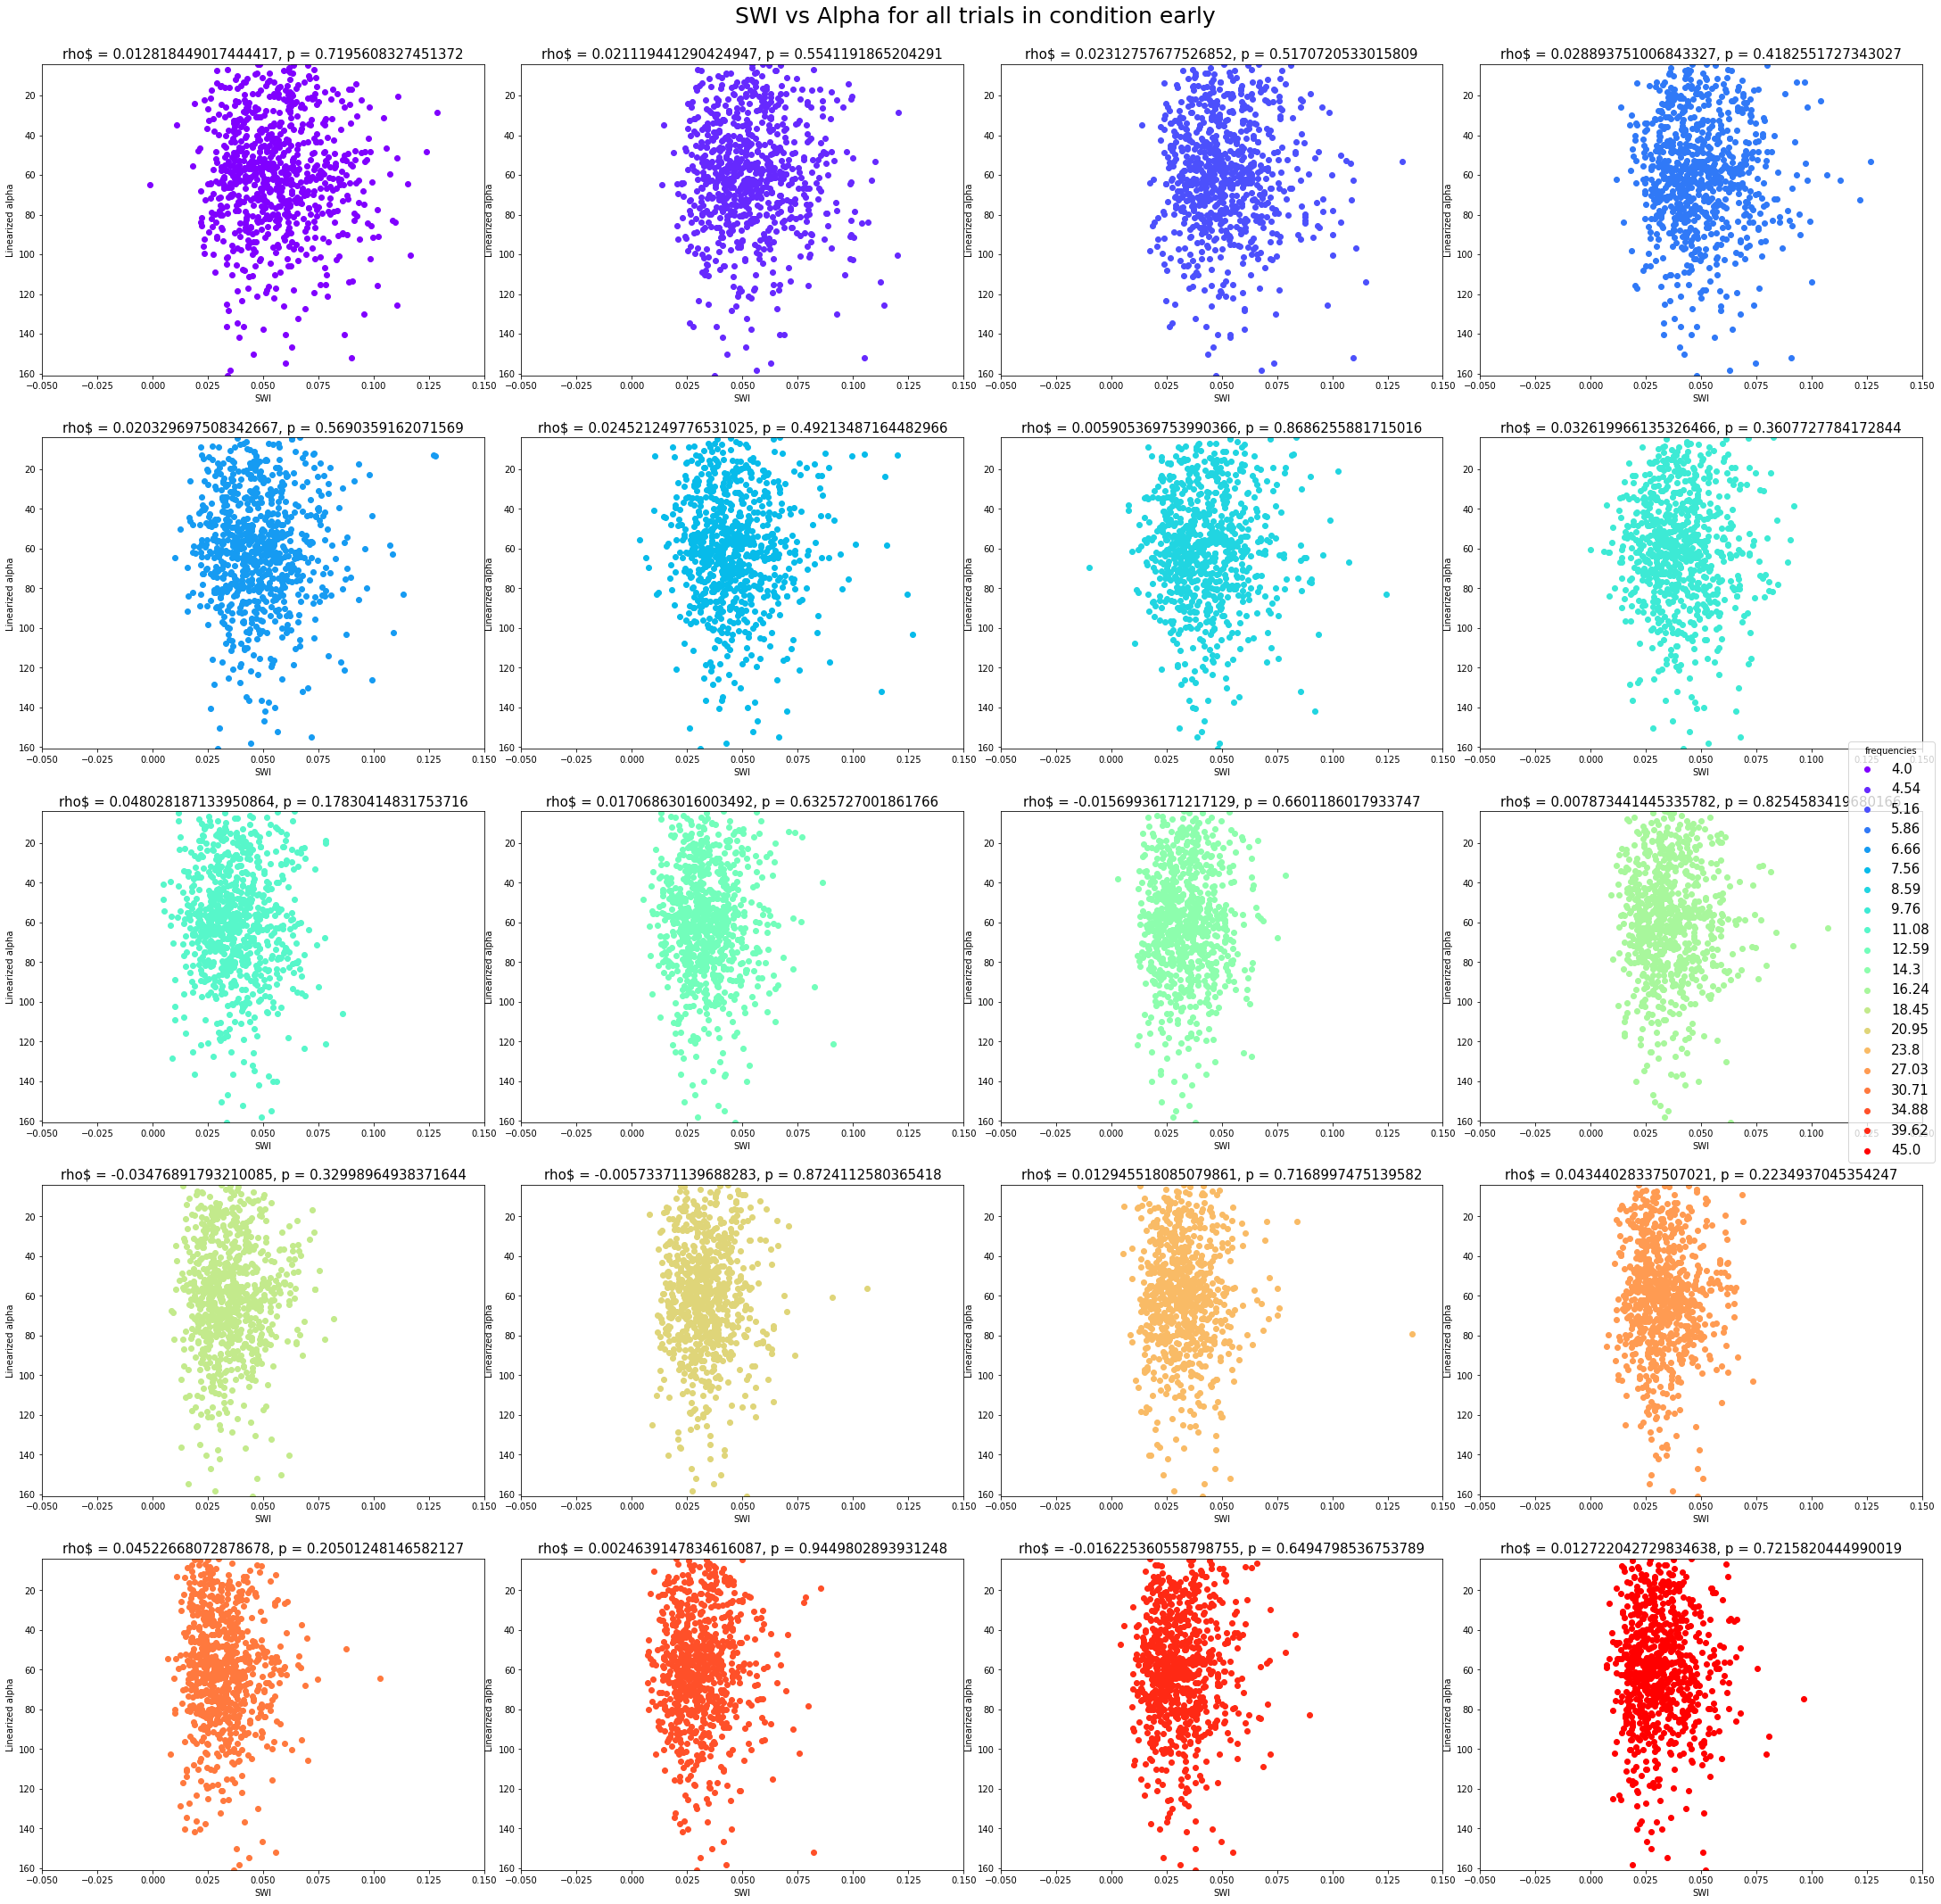

In [19]:
fig, axs = plt.subplots(5,4, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.suptitle("SWI vs Alpha for all trials in condition early",fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.subplots_adjust(hspace = .2)#, wspace=.001)
axs = axs.ravel()
color=iter(cm.rainbow(np.linspace(0,1,20)))

for freq_i in range(len(freqs_list)):
    swi = swi_early[:,freq_i]
    # np.mean(ispc_inter, axis=(1,2,3))
    x = swi
    y = alphalin_early

    rho, sig = pearsonr(x, y)
    c=next(color)
    axs[freq_i].scatter(x ,y, color=c)
    axs[freq_i].set_ylim(max(y), min(y))    
    axs[freq_i].set_xlim(-0.05, 0.15)  
    axs[freq_i].set_title("rho$ = {0}, p = {1}".format(rho, sig),fontsize=15)
    axs[freq_i].set_xlabel("SWI")
    axs[freq_i].set_ylabel("Linearized alpha")
fig.legend(freqs_list, title ="frequencies",fontsize=15, loc = "center right")
fig.savefig('SWI_alpha_early.pdf')

### Try with error bars, ignore

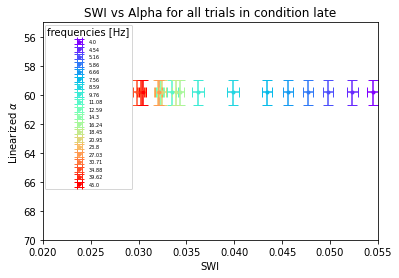

In [28]:
from scipy import stats
color=iter(cm.rainbow(np.linspace(0,1,20)))
#yerr = np.linspace(0.05, 0.2, 20)
#xerr = np.linspace(0.05, 0.2, 20)


for freq_i in range(len(freqs_list)):
    swi = swi_early[:,freq_i]
    x = swi.mean()
    y = alphalin_early.mean()
    sem_x = stats.sem(swi)
    sem_y =  stats.sem(alphalin_early)
    plt.xlim(0.02,0.055)
    plt.ylim(70, 55)   
    plt.errorbar(x, y,xerr = sem_x,yerr = sem_y, linestyle='None',fmt=".", capsize=5,color=next(color))
    plt.title("SWI vs Alpha for all trials in condition late")
    plt.xlabel("SWI")
    plt.ylabel(r"Linearized $\alpha$")
    #plt.annotate(freqs_list[freq_i], (x, y))
plt.legend(freqs_list, title ="frequencies [Hz]",fontsize=5, loc='upper left')
plt.savefig('SWI_alpha_early_errorbars.pdf')

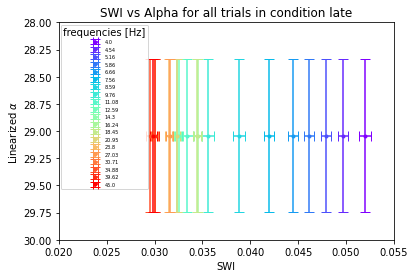

In [27]:
from scipy import stats
color=iter(cm.rainbow(np.linspace(0,1,20)))
#yerr = np.linspace(0.05, 0.2, 20)
#xerr = np.linspace(0.05, 0.2, 20)


for freq_i in range(len(freqs_list)):
    swi = swi_late[:,freq_i]
    x = swi.mean()
    y = alphalin_late.mean()
    sem_x = stats.sem(swi)
    sem_y =  stats.sem(alphalin_late)
    plt.xlim(0.02,0.055)
    plt.ylim(30, 28)   
    plt.errorbar(x, y,xerr = sem_x,yerr = sem_y,linestyle='None',fmt=".", capsize=5,color=next(color))
    plt.title("SWI vs Alpha for all trials in condition late")
    plt.xlabel("SWI")
    plt.ylabel(r"Linearized $\alpha$")
    #plt.annotate(freqs_list[freq_i], (x, y))
plt.legend(freqs_list, title ="frequencies [Hz]",fontsize=5, loc='upper left')
plt.savefig('SWI_alpha_late_errorbars.pdf')